In [56]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sentinelhub import SHConfig
from sentinelhub import (
    DataCollection,
    MimeType,
    SentinelHubRequest,
    bbox_to_dimensions,
)
import folium
from tqdm import tqdm
import math

In [57]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
from sentinelhub import CRS, BBox, bbox_to_dimensions
import cv2
import ee

config_sentinel = SHConfig(sh_client_id=os.environ.get("sh_client_id"), sh_client_secret=os.environ.get("sh_client_secret"))

In [60]:
from mapping_automation import find_best_date, subtract_km_from_coordinates, get_cloud_coverage, search_available_dates, get_access_token, get_slope_elevation
from scripts import *
from utils import *
import os
from dotenv import load_dotenv
load_dotenv()

True

In [59]:
date = "2024-02-01"
lat, lon = 11.356270, 75.839343
grid = 2
box_dim = 50 # km
res = 1000

In [ ]:
g = generate_grid(lat, lon, distance=box_dim*1000, grid_side=grid)
m = folium.Map(
    location=(lat, lon),
    zoom_start=15,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)   
for i in range(len(g)):
    folium.Rectangle([(g[i][:2]), (g[i][2:])], color='red', fill='pink',fill_opcity=0.5).add_to(m)

m

In [ ]:
row = 0
col = 0
get_new_dates_for_each = True

_box_dim = 1000 if box_dim < 100 else box_dim
canvas_NDVI_Before = np.zeros(((grid) * _box_dim, (grid) * _box_dim, 3), dtype=np.uint8)
canvas_NDVI_After = np.zeros(((grid) * _box_dim, (grid) * _box_dim, 3), dtype=np.uint8)
canvas_True_Color_After = np.zeros(((grid) * _box_dim, (grid) * _box_dim, 3), dtype=np.uint8)
canvas_LSM_Only_After = np.zeros(((grid) * _box_dim, (grid) * _box_dim, 3), dtype=np.uint8)

for idx, i in enumerate(range(len(g))):

    if get_new_dates_for_each or idx==0:
        lat, lon = g[idx][0], g[idx][1]
        print("Getting dates for new lat lon")
        available_dates = search_available_dates(target_date=date,
                                                lat = lat,
                                                lon = lon)
        available_dates_cloud_coverage = get_cloud_coverage(lat=lat, lon=lon, date_list=available_dates)
        min_before_date, min_before_cc, min_after_date, min_after_cc = find_best_date({k: v for k, v in available_dates_cloud_coverage.items() if v is not None}, target_date=date)
        print(min_before_date,":" , min_before_cc, min_after_date,":" ,min_after_cc)

    y_start = _box_dim * col
    y_end = _box_dim * (col + 1)
    x_start = _box_dim * row
    x_end = _box_dim * (row + 1)

    print("NDVI_Before")
    NDVI_Before = get_images(km=box_dim, grid=[g[i]], grid_dim=1, script=evalscript_NDVI, 
           date_start=min_before_date, date_end=min_before_date, res=res, 
           box_dim=box_dim)

    canvas_NDVI_Before[y_start:y_end, x_start:x_end] = NDVI_Before

    print("NDVI_After")
    NDVI_After = get_images(km=box_dim, grid=[g[i]], grid_dim=1, script=evalscript_NDVI, 
                date_start=min_after_date, date_end=min_after_date, res=res, 
                box_dim=box_dim)
    canvas_NDVI_After[y_start:y_end, x_start:x_end] = NDVI_After

    print("True_Color_After")
    True_Color_After = get_images(km=box_dim, grid=[g[i]], grid_dim=1, script=evalscript_True_Color, 
            date_start=min_after_date, date_end=min_after_date, res=res, 
            box_dim=box_dim)
    canvas_True_Color_After[y_start:y_end, x_start:x_end] = True_Color_After

    print("LSM_Only_After")
    LSM_Only_After = get_images(km=box_dim, grid=[g[i]], grid_dim=1, script=evalscript_lsm_only, 
                date_start=min_after_date, date_end=min_after_date, res=res, 
                box_dim=box_dim)
    canvas_LSM_Only_After[y_start:y_end, x_start:x_end] = LSM_Only_After

    row += 1  # Move to the next column
    if (idx + 1) % math.sqrt(len(g)) == 0:
        print("----") 
        col += 1  # Move to the next row
        row = 0  # Reset column position

diff = canvas_NDVI_Before - canvas_NDVI_After
threshold = 0
tolerance = 60
mask = ((canvas_NDVI_Before > canvas_NDVI_After + tolerance) & (diff > threshold)).astype(np.uint8) * 255
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
mask_resized = cv2.resize(mask, (mask.shape[0]//4, mask.shape[0]//4))
mask = cv2.resize(mask_resized, mask.shape)
mask = cv2.threshold(mask, 0, 255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

no_mask = np.ones_like(canvas_True_Color_After) * 255
LMS_True_Color_dNDVI_not_Masked = canvas_True_Color_After.copy()
mask_condition = no_mask == 255
LMS_True_Color_dNDVI_not_Masked[mask_condition] = canvas_LSM_Only_After[mask_condition]
black_pixels = np.all(LMS_True_Color_dNDVI_not_Masked == [0, 0, 0], axis=-1)
LMS_True_Color_dNDVI_not_Masked[black_pixels] = canvas_True_Color_After[black_pixels]

LMS_True_Color_dNDVI_Masked = canvas_True_Color_After.copy()
LMS_True_Color_dNDVI_Masked[mask[:,:, None].repeat(3, -1) == 255] = canvas_LSM_Only_After[mask[:,:, None].repeat(3, -1) == 255]

black_mask = np.all(LMS_True_Color_dNDVI_Masked == [0, 0, 0], axis=-1)
output = LMS_True_Color_dNDVI_Masked.copy()
LMS_True_Color_dNDVI_Masked[black_mask] = canvas_True_Color_After[black_mask]

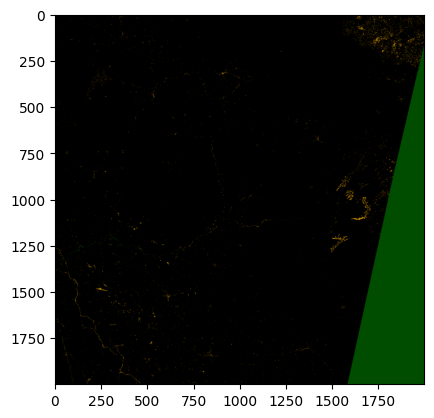

In [55]:
plt.imshow(canvas_LSM_Only_After)

In [ ]:
diff = NDVI_Before - NDVI_After
threshold = 0
tolerance = 60
mask = ((NDVI_Before > NDVI_After + tolerance) & (diff > threshold)).astype(np.uint8) * 255
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
mask_resized = cv2.resize(mask, (mask.shape[0]//4, mask.shape[0]//4))
mask = cv2.resize(mask_resized, mask.shape)
mask = cv2.threshold(mask, 0, 255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

no_mask = np.ones_like(True_Color_After) * 255
LMS_True_Color_dNDVI_not_Masked = True_Color_After.copy()
mask_condition = no_mask == 255
LMS_True_Color_dNDVI_not_Masked[mask_condition] = LSM_Only_After[mask_condition]
black_pixels = np.all(LMS_True_Color_dNDVI_not_Masked == [0, 0, 0], axis=-1)
LMS_True_Color_dNDVI_not_Masked[black_pixels] = True_Color_After[black_pixels]

LMS_True_Color_dNDVI_Masked = True_Color_After.copy()
LMS_True_Color_dNDVI_Masked[mask[:,:, None].repeat(3, -1) == 255] = LSM_Only_After[mask[:,:, None].repeat(3, -1) == 255]

black_mask = np.all(LMS_True_Color_dNDVI_Masked == [0, 0, 0], axis=-1)
output = LMS_True_Color_dNDVI_Masked.copy()
LMS_True_Color_dNDVI_Masked[black_mask] = True_Color_After[black_mask]

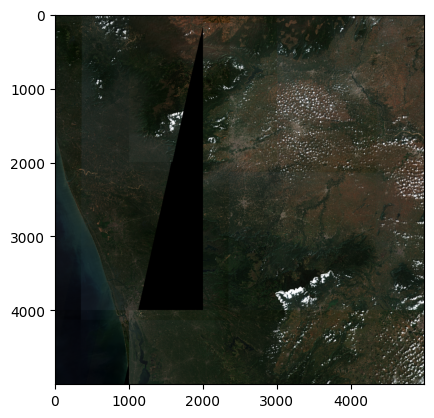

In [46]:
plt.imshow(canvas)

In [70]:
print("NDVI_Before")
NDVI_Before = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_NDVI, 
           date_start=min_before_date, date_end=min_before_date, res=res, 
           box_dim=box_dim)

print("NDVI_After")
NDVI_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_NDVI, 
            date_start=min_after_date, date_end=min_after_date, res=res, 
            box_dim=box_dim)

print("True_Color_After")
True_Color_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_True_Color, 
        date_start=min_after_date, date_end=min_after_date, res=res, 
        box_dim=box_dim)

print("LSM_Only_After")
LSM_Only_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_lsm_only, 
            date_start=min_after_date, date_end=min_after_date, res=res, 
            box_dim=box_dim)

print("Slope and Elevation")
slope_arr, elevation_arr = get_slope_elevation(g)
slope_arr = cv2.resize(slope_arr, (res,res))
elevation_arr = cv2.resize(elevation_arr, (res,res))

diff = NDVI_Before - NDVI_After
threshold = 0
tolerance = 60
mask = ((NDVI_Before > NDVI_After + tolerance) & (diff > threshold)).astype(np.uint8) * 255
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
mask_resized = cv2.resize(mask, (mask.shape[0]//4, mask.shape[0]//4))
mask = cv2.resize(mask_resized, mask.shape)
mask = cv2.threshold(mask, 0, 255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

no_mask = np.ones_like(True_Color_After) * 255
LMS_True_Color_dNDVI_not_Masked = True_Color_After.copy()
mask_condition = no_mask == 255
LMS_True_Color_dNDVI_not_Masked[mask_condition] = LSM_Only_After[mask_condition]
black_pixels = np.all(LMS_True_Color_dNDVI_not_Masked == [0, 0, 0], axis=-1)
LMS_True_Color_dNDVI_not_Masked[black_pixels] = True_Color_After[black_pixels]

LMS_True_Color_dNDVI_Masked = True_Color_After.copy()
LMS_True_Color_dNDVI_Masked[mask[:,:, None].repeat(3, -1) == 255] = LSM_Only_After[mask[:,:, None].repeat(3, -1) == 255]

black_mask = np.all(LMS_True_Color_dNDVI_Masked == [0, 0, 0], axis=-1)
output = LMS_True_Color_dNDVI_Masked.copy()
LMS_True_Color_dNDVI_Masked[black_mask] = True_Color_After[black_mask]


NDVI_Before
0 0 [11.044101, 75.863738, 11.053094216059186, 75.87290091297348] -> 0 1000 0 1000
0 1 [11.044101, 75.87290091297348, 11.053094216059186, 75.88206382594696] -> 0 1000 1000 2000
0 2 [11.044101, 75.88206382594694, 11.053094216059186, 75.89122673892042] -> 0 1000 2000 3000
0 3 [11.044101, 75.89122673892042, 11.053094216059186, 75.9003896518939] -> 0 1000 3000 4000
0 4 [11.044101, 75.9003896518939, 11.053094216059186, 75.90955256486738] -> 0 1000 4000 5000
----
1 0 [11.035107783940813, 75.863738, 11.044101, 75.87290091297348] -> 1000 2000 0 1000
1 1 [11.035107783940813, 75.87290091297348, 11.044101, 75.88206382594696] -> 1000 2000 1000 2000
1 2 [11.035107783940813, 75.88206382594694, 11.044101, 75.89122673892042] -> 1000 2000 2000 3000
1 3 [11.035107783940813, 75.89122673892042, 11.044101, 75.9003896518939] -> 1000 2000 3000 4000
1 4 [11.035107783940813, 75.9003896518939, 11.044101, 75.90955256486738] -> 1000 2000 4000 5000
----
2 0 [11.026114567881624, 75.863738, 11.0351077839

In [26]:
LMS_True_Color_dNDVI_Masked.shape

(2000, 2000, 3)

In [ ]:
plt.imshow(slope_arr)

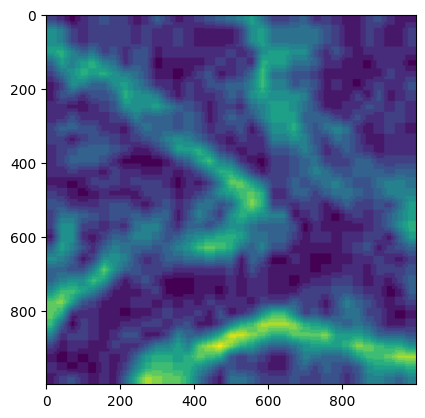

In [71]:
plt.imshow(slope_arr)

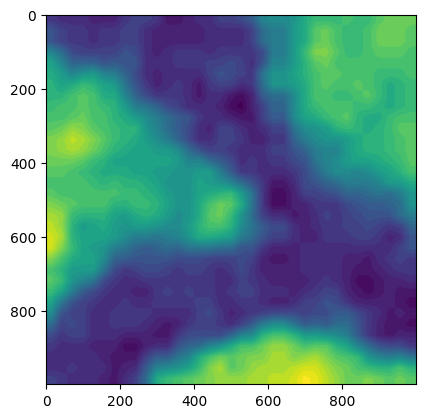

In [72]:
plt.imshow(elevation_arr)

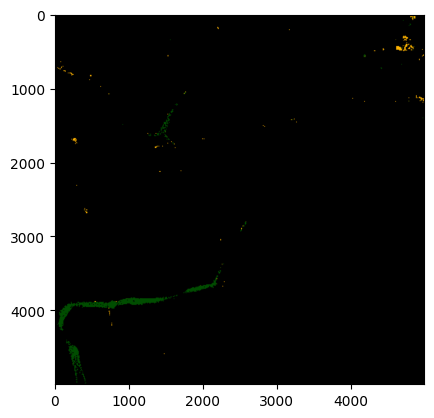

In [73]:
plt.imshow(LSM_Only_After)

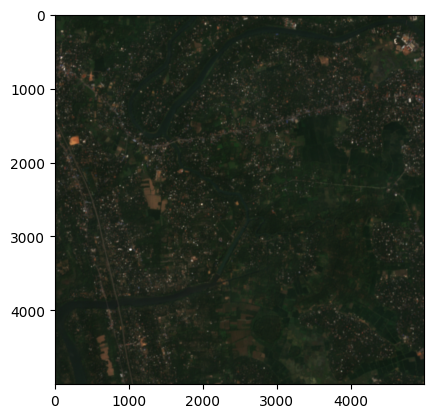

In [74]:
plt.imshow(True_Color_After)

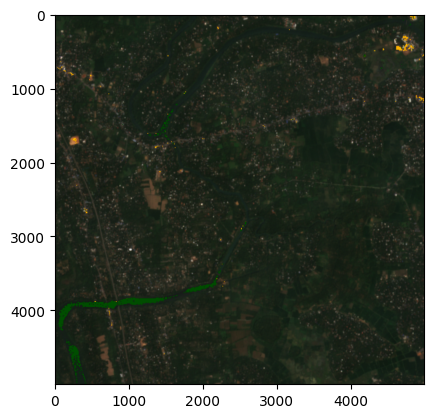

In [75]:
plt.imshow(LMS_True_Color_dNDVI_not_Masked)

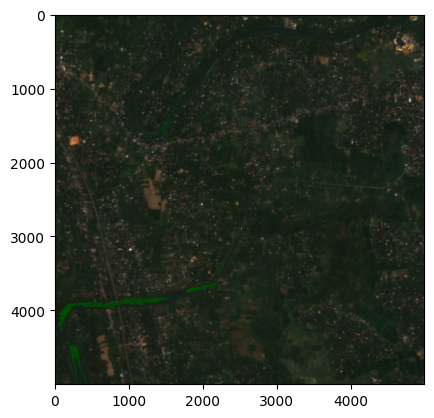

In [76]:
plt.imshow(LMS_True_Color_dNDVI_Masked)

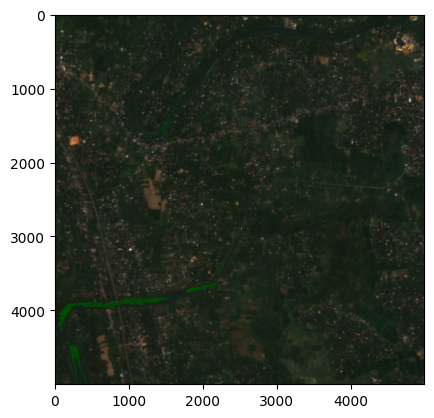

In [77]:
plt.imshow(LMS_True_Color_dNDVI_Masked)